In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import grangercausalitytests

## Задание 2


Есть ли интересные взаимосвязи между return-ами  различных инструментов в один и тот же период по времени? (Предположение: поиск корреляции, Granger causality, PCA decomposition of returns)

In [2]:
# Загружаем данные

apple = pd.read_csv('data/return_apple.csv')
facebook = pd.read_csv('data/return_facebook.csv')
google_a = pd.read_csv('data/return_google_a.csv')
google_c = pd.read_csv('data/return_google_c.csv')

In [3]:
# Переименуем колонку
apple = apple.rename(columns={'daily_returns':'apple'})
facebook = facebook.rename(columns={'daily_returns':'facebook'})
google_a = google_a.rename(columns={'daily_returns':'google_a'})
google_c = google_c.rename(columns={'daily_returns':'google_c'})

In [4]:
daily_returns = apple.merge(facebook, how='outer', on='date')\
                     .merge(google_a, how='outer', on='date')\
                     .merge(google_c, how='outer', on='date')

In [5]:
daily_returns

,date,apple,facebook,google_a,google_c
0,2012-08-24,0.018784,-0.013344,-0.013866,NaN
1,2012-08-27,-0.001302,0.009922,0.011999,NaN
2,2012-08-28,-0.001977,-0.012410,0.015888,NaN
3,2012-08-29,-0.014252,-0.000602,-0.009200,NaN
4,2012-08-30,0.002067,-0.053985,0.005002,NaN
...,...,...,...,...,...
2512,2022-08-19,-0.023029,-0.029233,-0.025339,-0.025821
2513,2022-08-22,-0.002029,-0.011898,-0.003326,-0.002607
2514,2022-08-23,0.001794,0.013345,-0.001493,-0.000610
2515,2022-08-24,0.014923,0.033811,0.026036,0.026155


In [6]:
daily_returns['date'] = pd.to_datetime(daily_returns['date'])
daily_returns = daily_returns.set_index(pd.DatetimeIndex(daily_returns['date']))
daily_returns = daily_returns.drop('date', axis=1)

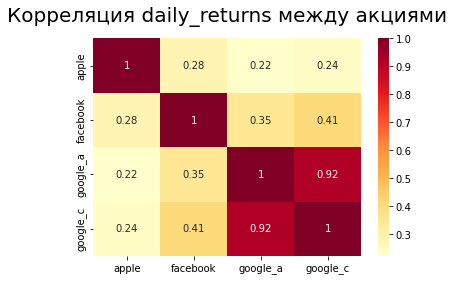

In [7]:
plt.title('Корреляция daily_returns между акциями', fontsize=20, y=1.05)
sns.heatmap(daily_returns.corr(), cmap='YlOrRd', annot=True )
plt.show()

Daily_returns у разных компаний не имеет сильной прямой линейной зависимости. Корреляция 0.92 - это у компании Google только по разным типам акций. Небольшая корреляция 20-40% - это, скорее всего, влияние внешней экономической ситуации.

Для наглядности можно посмотреть как выглядят зависимости на следующем графике:

Зависимости daily_returns между акциями


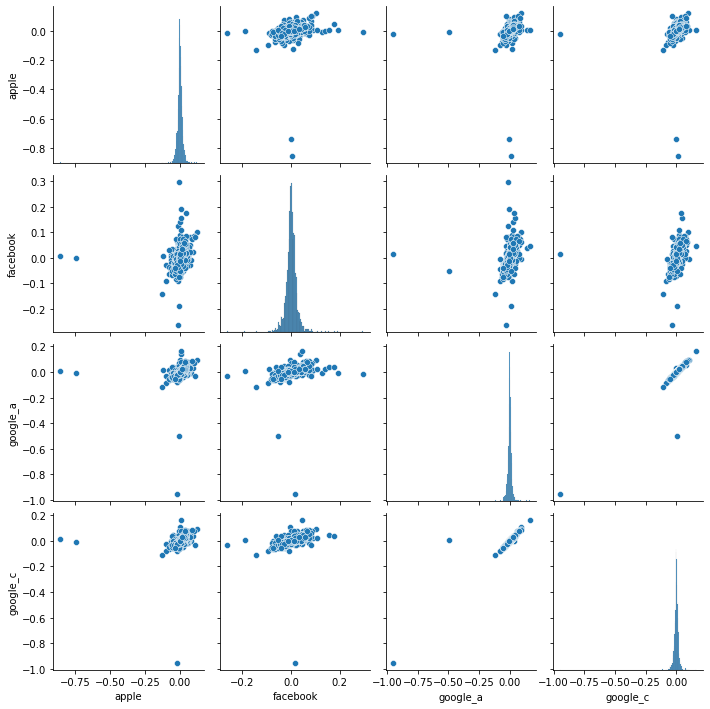

In [24]:
print('Зависимости daily_returns между акциями')
sns.pairplot(daily_returns)
plt.show()

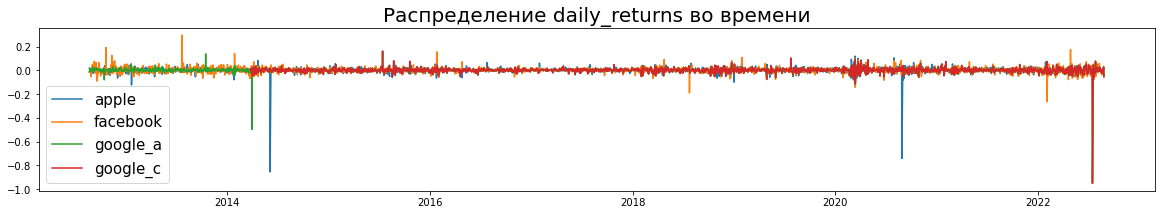

In [9]:
plt.figure(figsize=(20,3))
plt.title('Распределение daily_returns во времени', fontsize=20)
plt.plot(daily_returns['apple'], label='apple')
plt.plot(daily_returns['facebook'], label='facebook')
plt.plot(daily_returns['google_a'], label='google_a')
plt.plot(daily_returns['google_c'], label='google_c')
plt.legend(loc='lower left', fontsize=15)
plt.show()

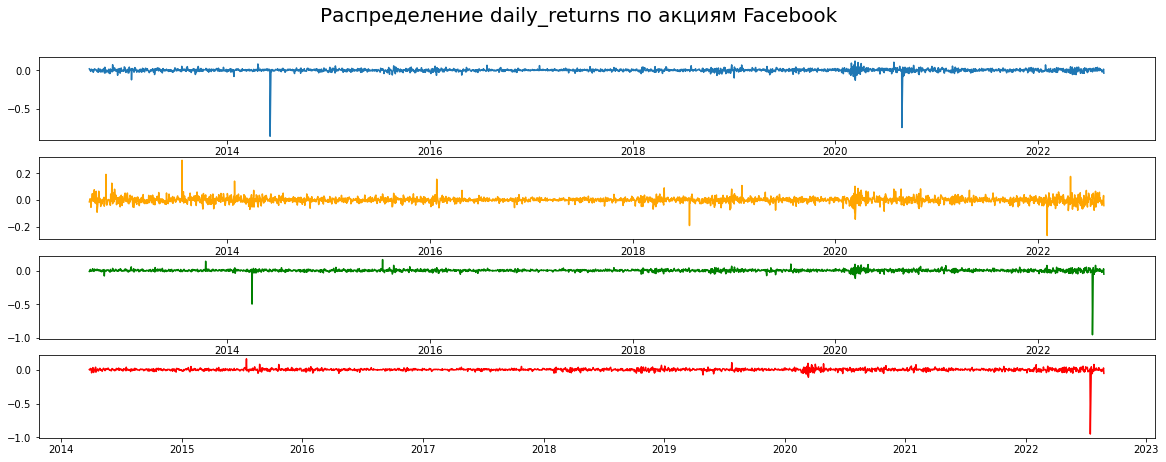

In [10]:
fig, ax = plt.subplots(4,1, figsize=(20,7))
fig.suptitle('Распределение daily_returns по акциям Facebook', fontsize=20)
ax[0].plot(daily_returns['apple'], label='apple')
ax[1].plot(daily_returns['facebook'], label='facebook', c='orange')
ax[2].plot(daily_returns['google_a'], label='google_a', c='g')
ax[3].plot(daily_returns['google_c'], label='google_c', c='r')
plt.show()

В основном daily_returns около 0. Но есть дни, когда стоимость акции резко менялась и у кажной акции это было в разные дни, что мы видим по пикам на графиках.


**Коррелограммы для нахождения лага к тесту Грейнджера**

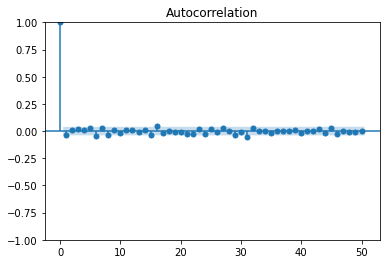

In [11]:
sm.graphics.tsa.plot_acf(daily_returns['apple'].squeeze(), lags=50)
plt.show()

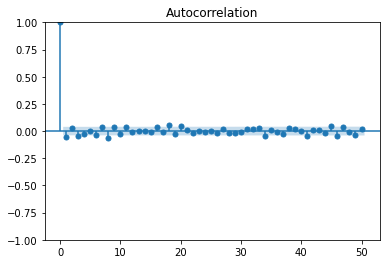

In [12]:
sm.graphics.tsa.plot_acf(daily_returns['facebook'].squeeze(), lags=50)
plt.show()

Коррелограммы данных рядов напоминают коррелограмму белого шума. maxlag можно брать 1 или 2.

**Тест на причинность Грейнджера** используется для определения того, полезен ли один временной ряд для прогнозирования другого.

В этом тесте используются следующие нулевая и альтернативная гипотезы:

- Нулевая гипотеза (H0): временной ряд x не является причиной Грейнджера временного ряда y
- Альтернативная гипотеза (HA): временной ряд x временной ряд причин Грейнджера y

Термин «причины Грейнджера» означает, что знание значения временного ряда x при определенном отставании полезно для прогнозирования значения временного ряда y в более поздний период времени.

Если p-значение меньше определенного уровня значимости (т. е. α = 0,05), то мы можем отклонить нулевую гипотезу и сделать вывод, что у нас есть достаточно доказательств, чтобы сказать, что временной ряд x по Грейнджеру вызывает временной ряд y.

In [13]:
maxlag=1
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [14]:
maxlag=1
grangers_causation_matrix(daily_returns, variables = ['apple', 'facebook', 'google_a'])

,apple_x,facebook_x,google_a_x
apple_y,1.0000,0.5106,0.1012
facebook_y,0.0052,1.0000,0.0166
google_a_y,0.1613,0.1478,1.0000


In [15]:
maxlag=1
grangers_causation_matrix(daily_returns[:500], variables = ['apple', 'facebook', 'google_a'])

,apple_x,facebook_x,google_a_x
apple_y,1.0000,0.5950,0.8763
facebook_y,0.5398,1.0000,0.1462
google_a_y,0.8744,0.7778,1.0000


In [16]:
maxlag=1
grangers_causation_matrix(daily_returns[500:1000], variables = ['apple', 'facebook', 'google_a'])

,apple_x,facebook_x,google_a_x
apple_y,1.0000,0.5369,0.3416
facebook_y,0.0027,1.0000,0.4831
google_a_y,0.2070,0.1861,1.0000


In [17]:
maxlag=1
grangers_causation_matrix(daily_returns[1000:1500], variables = ['apple', 'facebook', 'google_a'])

,apple_x,facebook_x,google_a_x
apple_y,1.0000,0.2512,0.7648
facebook_y,0.5935,1.0000,0.2566
google_a_y,0.2978,0.7622,1.0000


In [18]:
maxlag=1
grangers_causation_matrix(daily_returns[1500:2500], variables = ['apple', 'facebook', 'google_a'])

,apple_x,facebook_x,google_a_x
apple_y,1.0000,0.3160,0.0750
facebook_y,0.0381,1.0000,0.0002
google_a_y,0.0874,0.0224,1.0000


In [19]:
maxlag=2

grangers_causation_matrix(daily_returns, variables = ['apple', 'facebook', 'google_a'])

,apple_x,facebook_x,google_a_x
apple_y,1.0000,0.3168,0.1012
facebook_y,0.0043,1.0000,0.0059
google_a_y,0.1608,0.1478,1.0000


In [20]:
maxlag=2

grangers_causation_matrix(daily_returns[500:1000], variables = ['apple', 'facebook', 'google_a'])

,apple_x,facebook_x,google_a_x
apple_y,1.0000,0.5369,0.3416
facebook_y,0.0027,1.0000,0.4831
google_a_y,0.0735,0.1861,1.0000


In [21]:
maxlag=2
grangers_causation_matrix(daily_returns[1500:2500], variables = ['apple', 'facebook', 'google_a'])

,apple_x,facebook_x,google_a_x
apple_y,1.0000,0.1190,0.0750
facebook_y,0.0381,1.0000,0.0002
google_a_y,0.0649,0.0167,1.0000


По тесту Грейнджера в зависимости от времени и размера лага одни ряды то являются причиной, то нет. Постоянно причино-следственной зависимости тут нет.